## SHAP LGBM


In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import lightgbm as lgb
#%matplotlib inline

In [2]:
data = pd.read_csv('regression/final_elem_SP.csv')
data = data.drop(['TC_a','D_a','MEN_V_a','Mean_NfValence','EA_b','r_a',
'Mean_NdValence','r_b','Mean_GSbandgap','Number','Mean_GSmagmom','Mean_NfUnfilled',
'AM_b','MP_b','Mean_NsUnfilled','Mean_NsValence','MeanColumn','MEN_V_b',
'Mean_NdUnfilled','TC_b','D_b'], axis=1)
X = data.iloc[:,2:-1]
Y = data.iloc[:,1]

In [3]:
def read_param():  ## function for reading saved hyperparameters
    f0 = open('regression/best-paramters_lgb_optuna_TPE_plot1.txt','r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = float(b[4][1])
    p5 = float(b[5][1]); p6 = int(b[6][1]); p7 = int(b[7][1]); p8 = float(b[8][1])
#     p9 = int(b[9][1])
    return p1, p2, p3, p4, p5, p6, p7, p8

p1, p2, p3, p4, p5, p6, p7, p8 = read_param()
params = {'objective': 'regression', 'boosting_type': 'gbdt', 'lambda_l1': p1,
          'lambda_l2': p2, 'num_leaves': p3, 'feature_fraction': p4, 
          'bagging_fraction': p5, 'bagging_freq': p6, 'min_child_samples': p7,
          'learning_rate': p8} 

In [4]:
## retrieving the best model
random = 595 ## change accordingly
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = random)
reg = lgb.Booster(model_file='regression/best_model_lgbm1.txt')
d_train = lgb.Dataset(X_train, label = Y_train)
reg = lgb.train(params, d_train)
Y_pred_test = reg.predict(X_test) 
Y_pred_train = reg.predict(X_train) 
rmse_test=np.sqrt(mean_squared_error(Y_test, Y_pred_test))
rmse_train=np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print(rmse_train, rmse_test) ## compare with the one obtained from finding the best ML model step

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4650
[LightGBM] [Info] Number of data points in the train set: 4749, number of used features: 26
[LightGBM] [Info] Start training from score 209.187568
32.051221529069664 47.479351797606405


## SHAP feature importance plot

## Global Interpretability

In [5]:
explainerModel = shap.TreeExplainer(model = reg)
shap_values = explainerModel.shap_values(X)

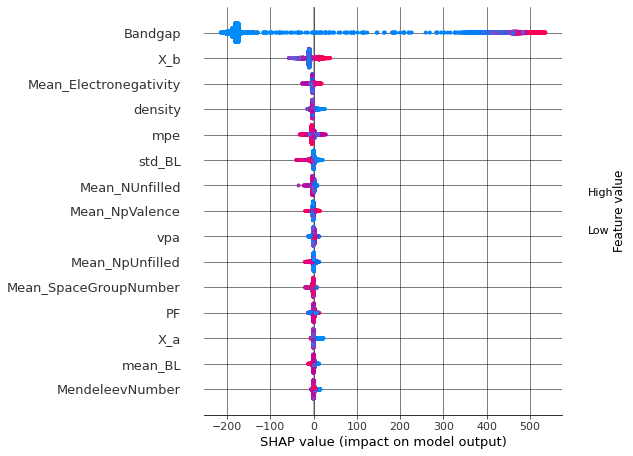

<Figure size 432x288 with 0 Axes>

In [7]:
## Summary plot (Global interpretability)
plt.figure(figsize=(20,20))
plt.grid(color='black', linestyle='-', linewidth=0.5)
shap.summary_plot(shap_values, features = X, feature_names=X.columns, color=plt.get_cmap("coolwarm"), max_display=15)
plt.show()
plt.savefig('images/shap_feature-importance.tif',bbox_inches='tight',  dpi=1000)

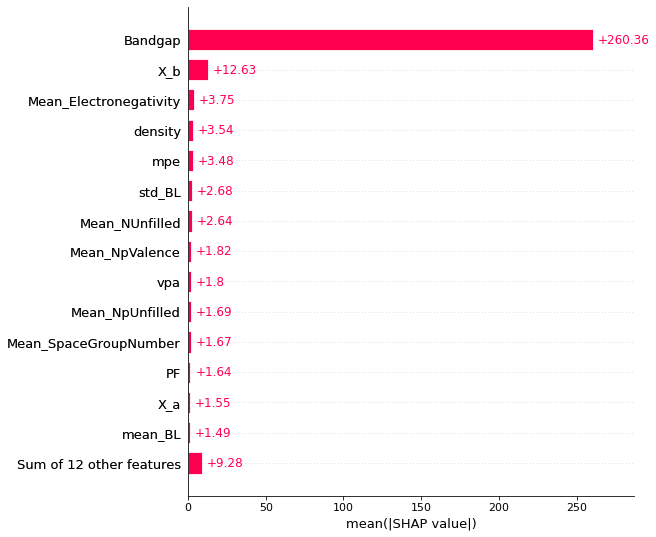

<Figure size 432x288 with 0 Axes>

In [9]:
import shap
plt.figure(figsize=(20,20))
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.bar(shap_values, max_display=15) # default is max_display=12
plt.savefig('images/shap_feature-importance.tif',bbox_inches='tight',  dpi=1000)

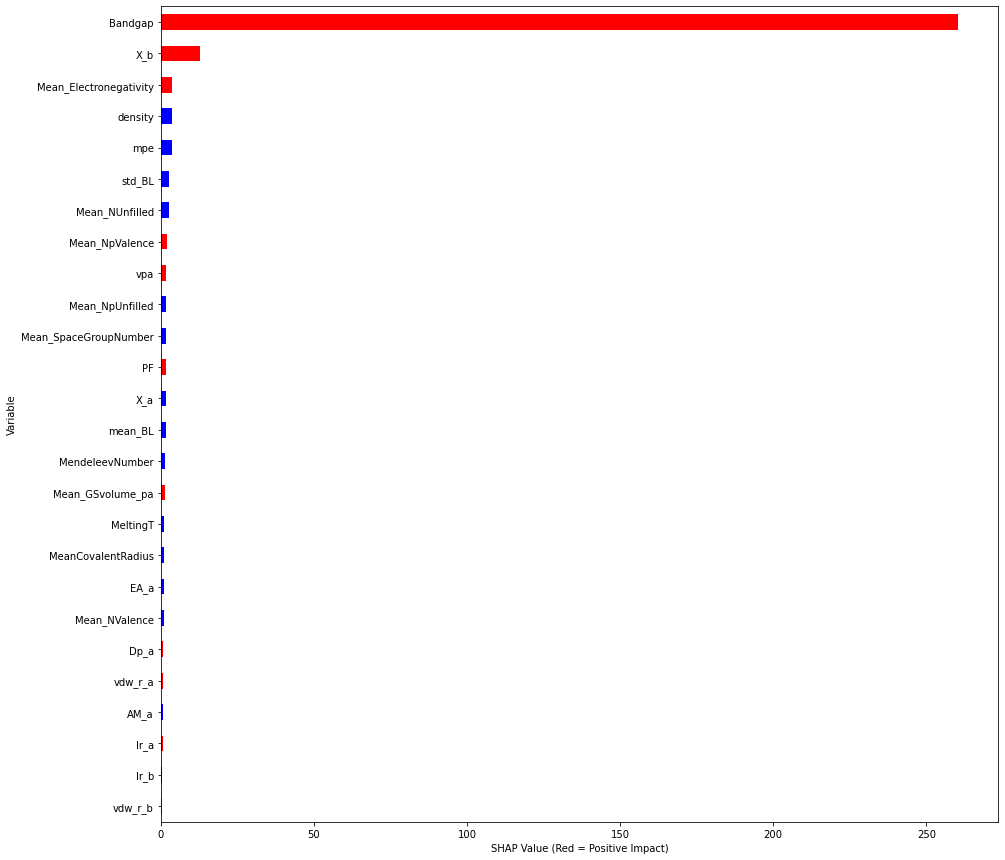

In [10]:
## 2nd type of bar plot of feature importance 
def abs_shap(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(15,15),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    plt.savefig('images/shap_feature-import_bar_convex.png', bbox_inches='tight', dpi=1000)

shap_values = explainerModel.shap_values(X)   
abs_shap(shap_values, X)

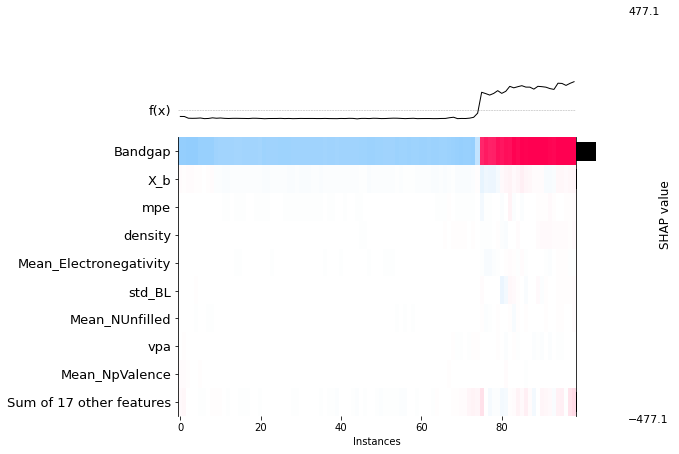

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [11]:
import shap
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.heatmap(shap_values[1:100])
plt.figure(figsize=(20,20))
#plt.savefig('final_images/shap_feature-heatmap.png',bbox_inches='tight',  dpi=1000)

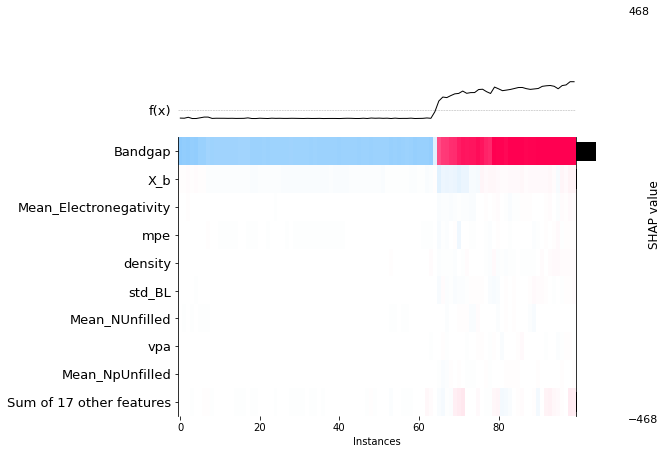

In [12]:
import shap
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.heatmap(shap_values[100:200])
#plt.savefig('images/shap_feature-heatmap2.png',bbox_inches='tight',  dpi=1000)

## Shap Interaction values

In [13]:
#Get SHAP interaction values
explainer = shap.TreeExplainer(reg)
shap_interaction = explainer.shap_interaction_values(X)

In [14]:
#Get shape of interaction values
print(np.shape(shap_interaction))

# SHAP interaction values for first compounds
pd.DataFrame(shap_interaction[0],index=X.columns,columns=X.columns)

(6785, 26, 26)


,Bandgap,mpe,PF,X_b,std_BL,mean_BL,vdw_r_b,Mean_NpValence,Mean_Electronegativity,density,...,Mean_NUnfilled,MeltingT,Mean_NValence,X_a,Mean_GSvolume_pa,Mean_SpaceGroupNumber,MeanCovalentRadius,Dp_a,Mean_NpUnfilled,AM_a
Bandgap,-196.396454,1.874290,0.923035,-3.749420,-2.756312,-0.874612,-0.016969,0.152048,-1.634490,0.949164,...,-0.347998,-0.256087,0.761847,-0.091831,-0.377392,-2.059167,-0.348609,-0.535778,-0.128207,0.166992
mpe,1.874290,-1.697462,-0.616075,-1.011631,0.531226,0.838121,-0.074456,0.100696,0.380968,-0.005263,...,0.202148,-0.052316,0.146684,0.088092,0.139401,-0.472885,0.241037,0.018068,-0.050607,-0.107056
PF,0.923035,-0.616075,-0.317342,-0.570383,-0.177045,0.142986,0.009200,-0.785941,0.466054,0.238077,...,0.015344,0.247547,-0.328597,0.610302,-0.040053,-0.609416,-0.264974,-0.166656,-0.041422,-0.048819
X_b,-3.749420,-1.011631,-0.570383,12.776033,0.034290,-0.048125,-0.045701,-0.173844,0.220803,-0.274229,...,0.118593,-0.144793,0.229482,-0.161042,0.027845,-0.361424,-0.093725,-0.064375,-0.117077,0.037518
std_BL,-2.756312,0.531226,-0.177045,0.034290,5.874892,0.197433,-0.001023,0.024858,0.019016,0.131372,...,-0.152332,-0.123393,-0.020945,-0.002269,0.053934,-0.054181,0.106697,-0.323118,-0.004753,0.204541
mean_BL,-0.874612,0.838121,0.142986,-0.048125,0.197433,0.893458,-0.000962,0.084677,-0.242878,0.434262,...,0.010829,-0.076519,0.021710,-0.066279,-0.022898,0.358561,0.454831,0.123069,0.006085,-0.030252
vdw_r_b,-0.016969,-0.074456,0.009200,-0.045701,-0.001023,-0.000962,-0.084958,0.059883,0.118523,-0.034345,...,0.001870,0.007257,-0.001799,0.001021,0.002575,-0.003076,-0.004983,0.011979,-0.005748,-0.005225
Mean_NpValence,0.152048,0.100696,-0.785941,-0.173844,0.024858,0.084677,0.059883,1.892034,-0.186146,0.067460,...,-0.149965,-0.742896,-0.023875,-0.538747,-0.008689,-0.027067,-0.233806,-0.205800,-0.376378,0.060573
Mean_Electronegativity,-1.634490,0.380968,0.466054,0.220803,0.019016,-0.242878,0.118523,-0.186146,2.868316,0.047255,...,-0.236877,0.228328,0.007572,0.130052,0.027399,-0.033928,-0.355774,0.008037,0.030074,0.054628
density,0.949164,-0.005263,0.238077,-0.274229,0.131372,0.434262,-0.034345,0.067460,0.047255,-3.539742,...,-0.238673,-0.140227,-0.002878,0.170166,0.049835,0.258343,0.116138,-0.005988,0.002566,-0.152896


In [15]:
#Get model predictions
y_pred = reg.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for the formation energy
sum_shap = np.sum(shap_interaction[0])

print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

print(mean_pred, sum_shap)

Model prediction: 7.367214173253761
Mean prediction + interaction values: 7.618565922942139
210.1304028743172 -202.51183695137507


# Interaction


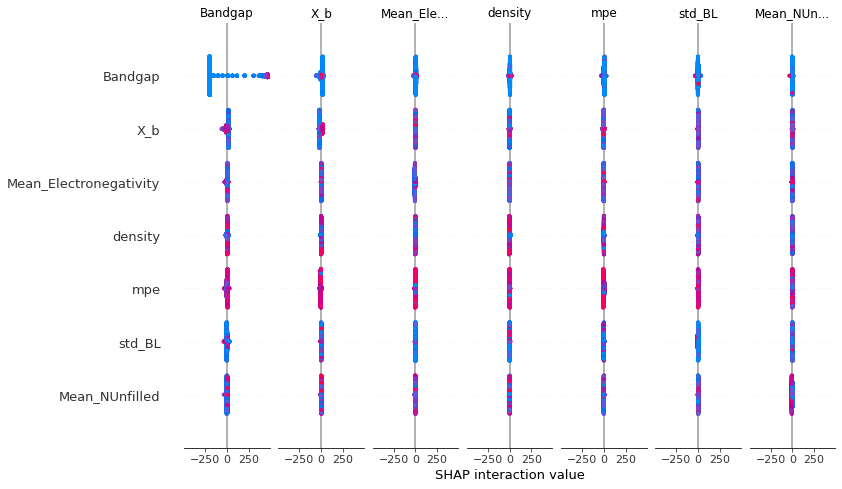

In [16]:
#Display summary plot
shap.summary_plot(shap_interaction, features = X, feature_names=X.columns, color=plt.get_cmap("cool"), max_display=7)
#plt.savefig('final_images3/shap_feature-interaction.png',bbox_inches='tight',  dpi=1000)

## Absolute Mean

In [15]:
# Get absolute mean of matrices
#mean_shap = np.abs(shap_interaction).mean(0)
#df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
#df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
#plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
#sns.set(font_scale=1.5)
#sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
#plt.yticks(rotation=0) 
#
#plt.savefig('images/shap_dp_min_Mendeleev_number.png', bbox_inches='tight', dpi=1000)

## SHAP dependence plots

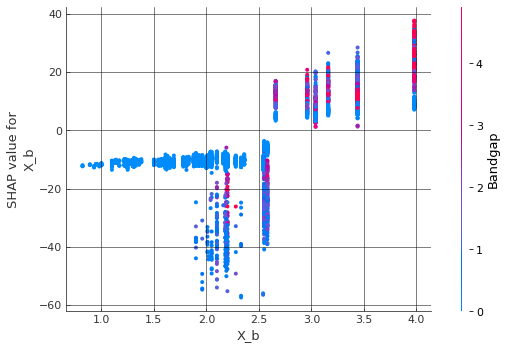

In [17]:
explainerModel = shap.TreeExplainer(model = reg)
shap_values = explainerModel.shap_values(X)
shap.dependence_plot('X_b', shap_values, X, show=False)
#plt.title("Ave. Atomic Radius Dependence Plot")
#plt.ylabel("SHAP value for Ave. Atomic Radius")
#plt.xlabel("Ave. Atomic Radius")
#plt.axis([0.5, 2.0, -1.0, 1.0])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
#plt.savefig('final_images3/shap_dp_avg_Atomic_Radius.png', bbox_inches='tight', dpi=1000)

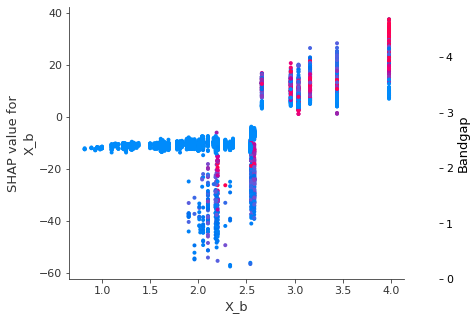

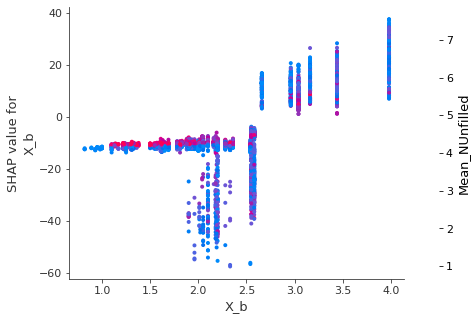

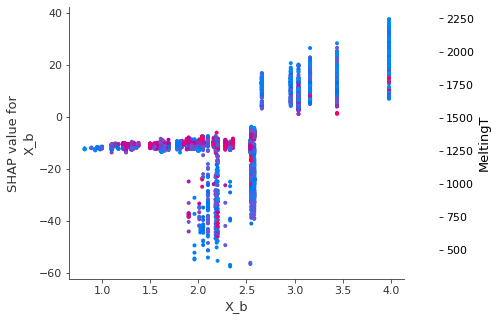

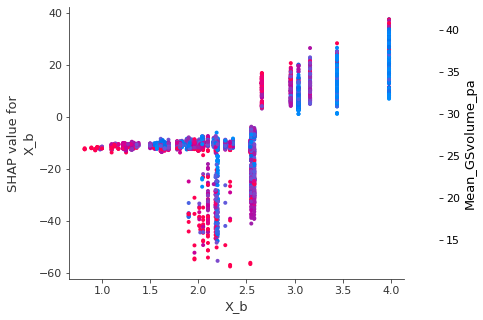

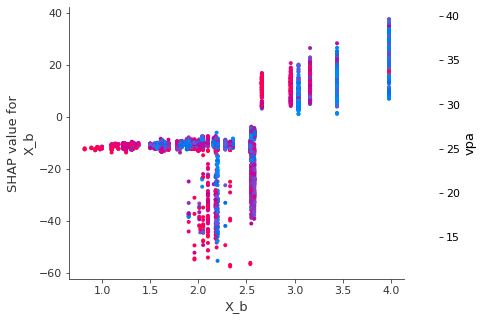

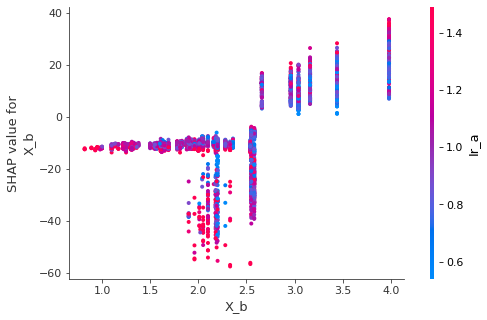

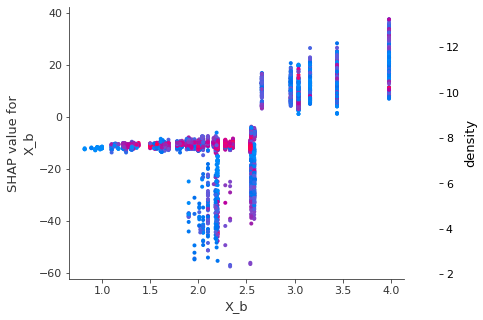

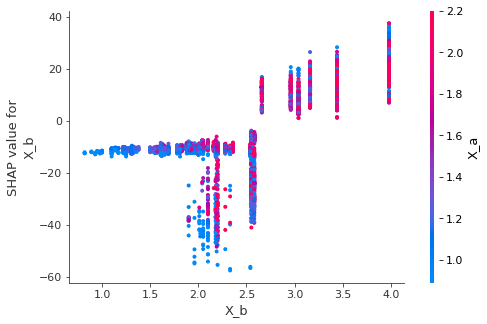

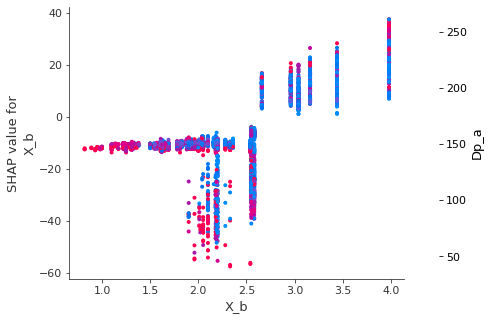

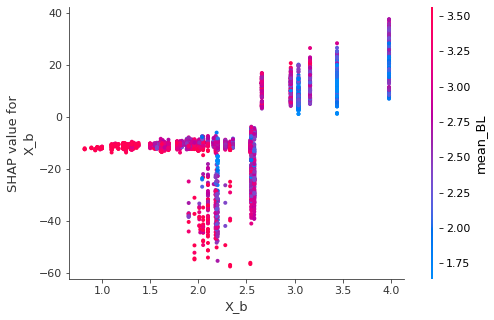

In [18]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions('X_b', shap_values, X)

# make plots colored by each of the top three possible interacting features
for i in range(10):
    shap.dependence_plot('X_b', shap_values, X, interaction_index=inds[i])



In [ ]:
shap.dependence_plot("avg_Atomic_Radius", shap_values, X, show = False, interaction_index='range_polarizability')
#plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP value for Ave. Atomic Radius")
plt.xlabel("Average Atomic Radius")
plt.axis([0.5, 2.1, -1.5, 1.5])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
#plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('range_polarizability', shap_values, X, show = False, interaction_index="avg_Atomic_Radius")
plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP I. for R. Polar. & Ave. Atomic Radius")
plt.xlabel("Range Polarizability")
plt.axis([0.0, 60.0, -0.75, 0.75])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
#plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('range_polarizability', shap_values, X, show = False, interaction_index="avg_Atomic_Radius")
plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP value for Range Polarizability")
plt.xlabel("Range Polarizability")
#plt.axis([0.0, 60.0, -1.25, 0.75])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('range_polarizability', shap_values, X, show = False)
plt.title("Range Polarizability Dependence Plot")
plt.ylabel("SHAP value for Range Polarizability")
plt.xlabel("Range Polarizability")
plt.axis([0.0, 60.0, -1.25, 0.75])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_range_polarizability.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_Density', shap_values, X, show =False)
plt.title("Ave. Density Dependence Plot")
plt.ylabel("SHAP Value for Ave. Density")
plt.xlabel("Ave. Density")
plt.axis([0, 8.5, -0.4,0.3])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_Density.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_l_quantum_number', shap_values, X, show=False)
plt.title("Ave. L. Quantum Number Dependence Plot")
plt.ylabel("SHAP Value for Ave. L. Quantum Number")
plt.xlabel("Ave. L. Quantum Number")
plt.axis([0.0, 2.00, -0.8, 0.4])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_l_quantum_number.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('dev_Atomic_Number', shap_values, X, show=False)
plt.title("Dev. Atomic Number Dependence Plot")
plt.ylabel("SHAP Value for Dev. Atomic Number")
plt.xlabel("Dev. Atomic Number")
plt.axis([0.0, 35.00, -0.8, 0.6])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_dev_Atomic_Number.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_crystal_radius', shap_values, X, show=False)
plt.title("Ave. Crystal Radius Dependence Plot")
plt.ylabel("SHAP Value for Ave. Crystal Radius")
plt.xlabel("Ave. Crystal Radius")
plt.axis([0.4, 1.80, -0.5, 0.4])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_crystal_radius.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('avg_Pauling_Electronegativity', shap_values, X, show=False)
plt.title("Ave. Pauling Electronegativity Dependence Plot")
plt.ylabel("SHAP Value for Ave. Pauling Electronegativity")
plt.xlabel("Ave. Pauling Electronegativity")
#plt.axis([0.4, 1.80, -0.5, 0.4])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_avg_Pauling_Electronegativity.png', bbox_inches='tight', dpi=1000)

In [ ]:
shap.dependence_plot('min relative bond length', shap_values, X, show=False)
plt.title("Min. Relative Bond Length Dependence Plot")
plt.ylabel("SHAP Value for Min. Relative Bond Length")
plt.xlabel("Min. Relative Bond Length")
plt.axis([0.6, 1.0, -0.3, 0.3])
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.tick_params(axis='both', direction='in')
plt.savefig('final_images3/shap_dp_min_relative_bond_length.png', bbox_inches='tight', dpi=1000)

## SHAP force plots

In [20]:
## Local interpretability
shap.initjs()
def plot_indiv_shap(i):
    shap.force_plot(explainerModel.expected_value, shap_values[i], X.iloc[[i]], show=False, matplotlib=True)
#     f = 'shap_individual_' + str(i) + '.png'
#     plt.savefig(f, bbox_inches='tight', dpi=300)

In [21]:
data.head()

,formula,S_p,Bandgap,mpe,PF,X_b,std_BL,mean_BL,vdw_r_b,Mean_NpValence,...,MeltingT,Mean_NValence,X_a,Mean_GSvolume_pa,Mean_SpaceGroupNumber,MeanCovalentRadius,Dp_a,Mean_NpUnfilled,AM_a,MP_a
0,ReO3,0.336845,0.000000,0.311128,0.276212,3.44,0.000001,1.913169,1.52,3.00,...,905.8500,9.75,1.90,10.492500,57.50,87.25,62.0000,1.50,186.207000,3459.00
1,Yb3Mg,14.406792,0.000000,0.740480,0.573238,1.31,0.000000,3.690337,1.73,0.00,...,1049.7500,12.50,1.10,31.312500,217.25,175.50,139.0000,0.00,173.040000,1097.00
2,B9H11,638.974583,2.911795,0.101052,0.125865,2.20,0.059786,1.236931,1.10,0.45,...,1064.3055,1.90,2.04,6.865875,181.40,54.85,20.5000,2.25,10.811000,2349.00
3,Li3Ga7,9.061345,0.000000,0.542895,0.555130,1.81,0.073217,2.838474,1.87,0.70,...,348.1440,9.40,0.98,18.178250,113.50,123.80,164.1125,3.50,6.941000,453.69
4,Sc3Cd,22.887388,0.000000,0.713049,0.719525,1.69,0.004315,3.206197,2.18,0.00,...,1509.0550,5.25,1.36,21.550000,194.00,163.50,97.0000,0.00,44.955912,1814.00


In [22]:
Y

0         0.336845
1        14.406792
2       638.974583
3         9.061345
4        22.887388
           ...    
6780      1.943270
6781      1.094291
6782      7.885090
6783      2.647826
6784      4.178441
Name: S_p, Length: 6785, dtype: float64

In [23]:
comp = data['Compound']
print(comp.iloc[1],   Y.iloc[1])
print(comp.iloc[2],   Y.iloc[2])
print(comp.iloc[7],      Y.iloc[7])
print(comp.iloc[229],    Y.iloc[229])

print(comp.iloc[80],   Y.iloc[80])
print(comp.iloc[80],   Y.iloc[80])

LiAl2Cu 0.212144053
LiMnAs 1.221144383
LiFeAs 1.462982653
LiCoS2 1.978878433
LiTiNCl 1.337883748


In [24]:
plot_indiv_shap(1) #for LiAl2Cu
plt.savefig('local/local_interpretability_1.png', bbox_inches='tight', dpi=2000)

MemoryError: Unable to allocate 324. MiB for an array with shape (2161, 19664) and data type int64

In [17]:
plot_indiv_shap(2) #for LiAl2Cu
plt.savefig('local/local_interpretability_2.png', bbox_inches='tight', dpi=1000)

In [18]:
plot_indiv_shap(7) #for LiAl2Cu
plt.savefig('local/local_interpretability_7.png', bbox_inches='tight', dpi=1000)

In [19]:
plot_indiv_shap(229) #for LiAl2Cu
plt.savefig('local/local_interpretability_229.png', bbox_inches='tight', dpi=1000)

In [12]:
y = list(range(150,500,1))

In [23]:
for i in y:
    explainerModel = shap.TreeExplainer(model = reg)
    shap_values = explainerModel.shap_values(X)
    plot_indiv_shap(i) # for Al5(CoO4)3
    plt.savefig('local/{fname}.png'.format(fname=i), dpi=500)

NameError: name 'y' is not defined

In [29]:
plot_indiv_shap(2) #for LiTiSe2
plt.savefig('final_images/local_interpretability_LiMnAs.png', bbox_inches='tight', dpi=1000)

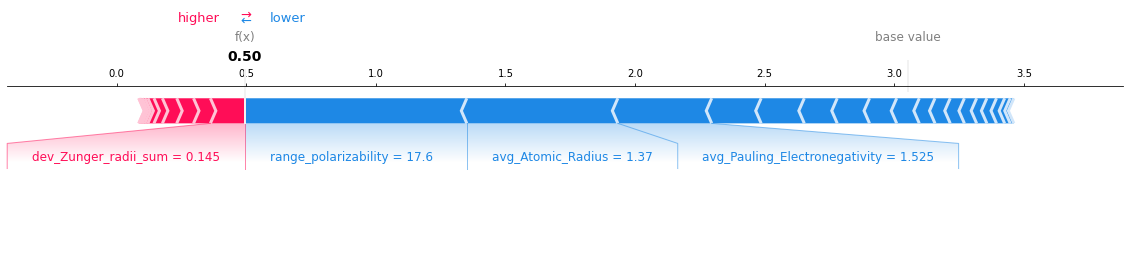

In [118]:
plot_indiv_shap(1) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_LiAl2Cu_1.png', bbox_inches='tight', dpi=1000)

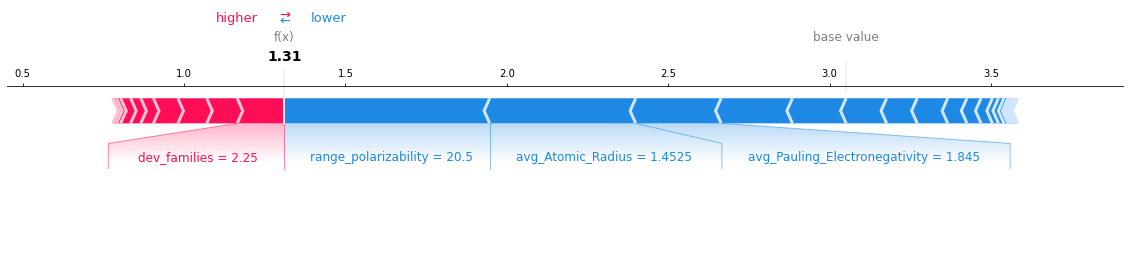

In [119]:
plot_indiv_shap(587) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_LiHfSe2.png', bbox_inches='tight', dpi=1000)

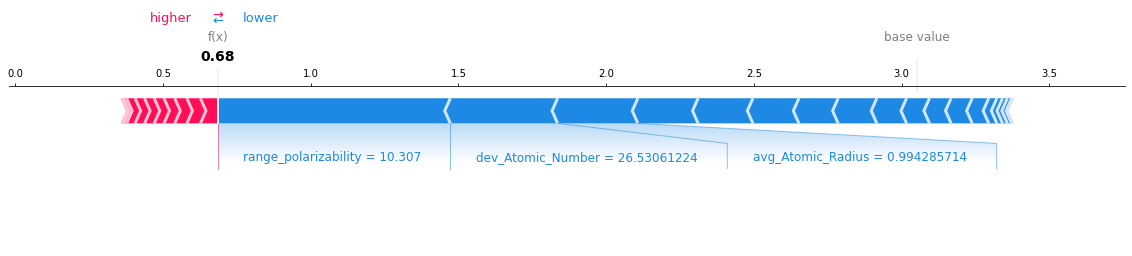

In [120]:
plot_indiv_shap(1527) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Al(WO2)2.png', bbox_inches='tight', dpi=1000)

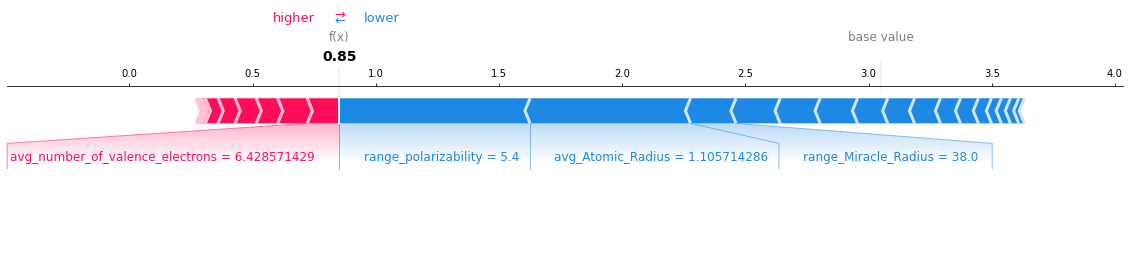

In [121]:
plot_indiv_shap(1547) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Al(CoS2)2.png', bbox_inches='tight', dpi=1000)

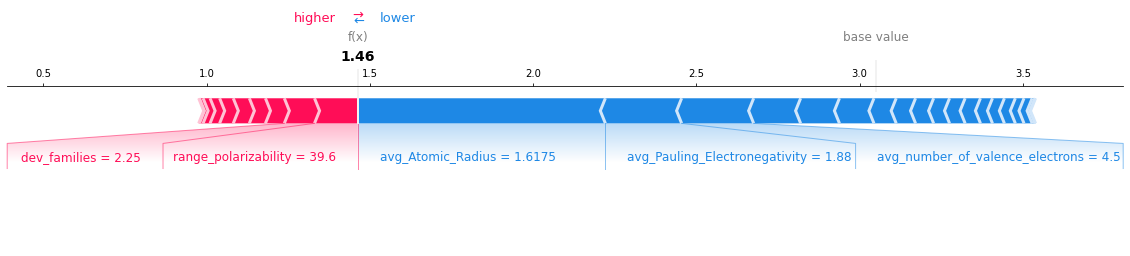

In [122]:
plot_indiv_shap(2009) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_KNbSe2.png', bbox_inches='tight', dpi=1000)

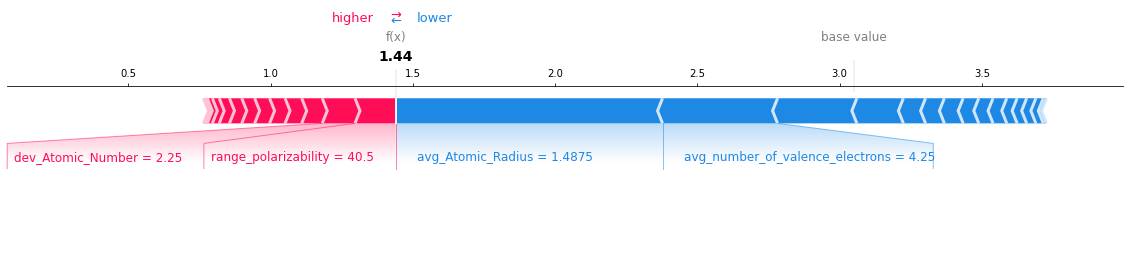

In [123]:
plot_indiv_shap(2042) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_KTiS2.png', bbox_inches='tight', dpi=1000)

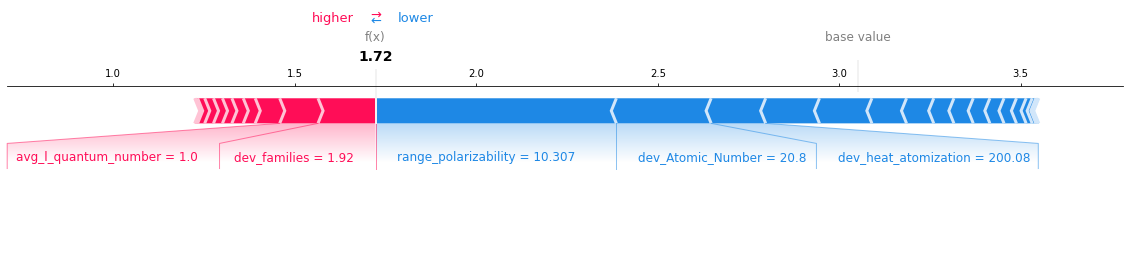

In [124]:
plot_indiv_shap(2236) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_MgWO3.png', bbox_inches='tight', dpi=1000)

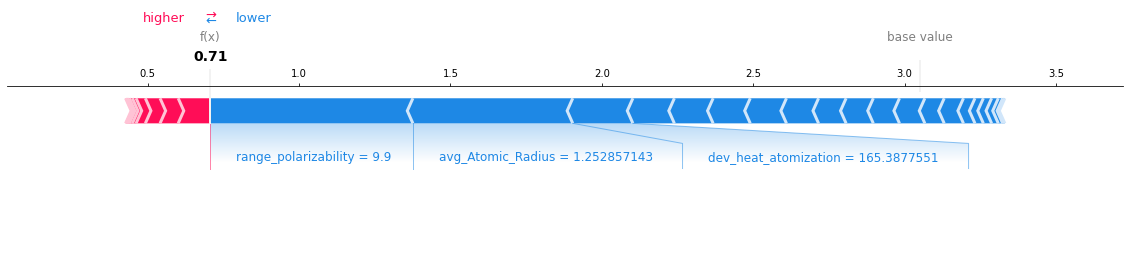

In [125]:
plot_indiv_shap(2311) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Mg(MoS2)2.png', bbox_inches='tight', dpi=1000)

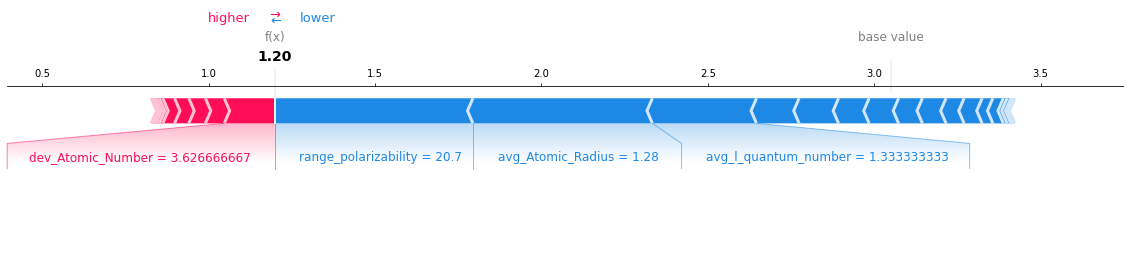

In [126]:
plot_indiv_shap(2496) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Na(V3S4)2.png', bbox_inches='tight', dpi=1000)

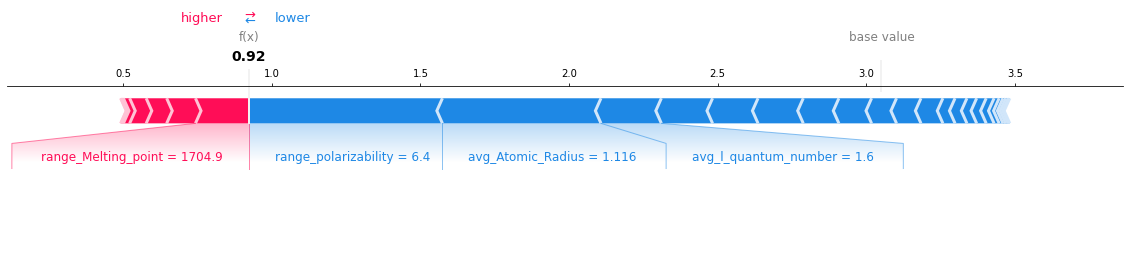

In [129]:
plot_indiv_shap(2761) # for LiAl2Cu
plt.savefig('final_images/local_interpretability_Zn(CoN)2.png', bbox_inches='tight', dpi=1000)

In [156]:
plot_indiv_shap(1859) # for LiAl2Cu
plt.savefig('final_images/local_interpretability.png', bbox_inches='tight', dpi=1000)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

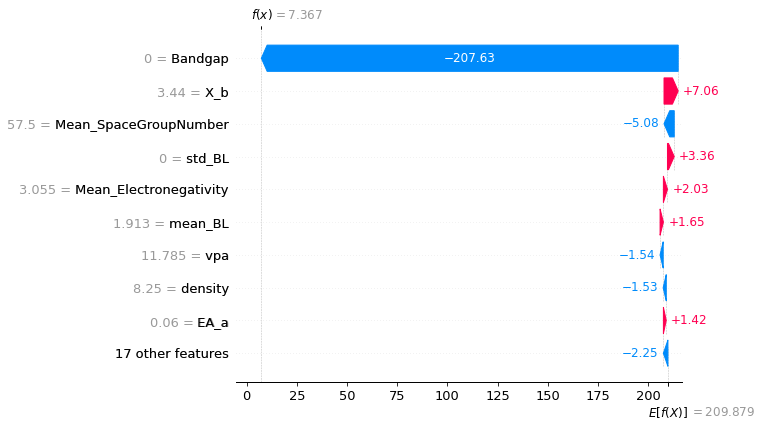

In [24]:
import shap
explainer = shap.Explainer(reg)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0]) # For the Al12Mo observation
#plt.savefig('final_images3/local_interpretability_LiTb4Al2(FeO6)2_2.png', bbox_inches='tight', dpi=1000)

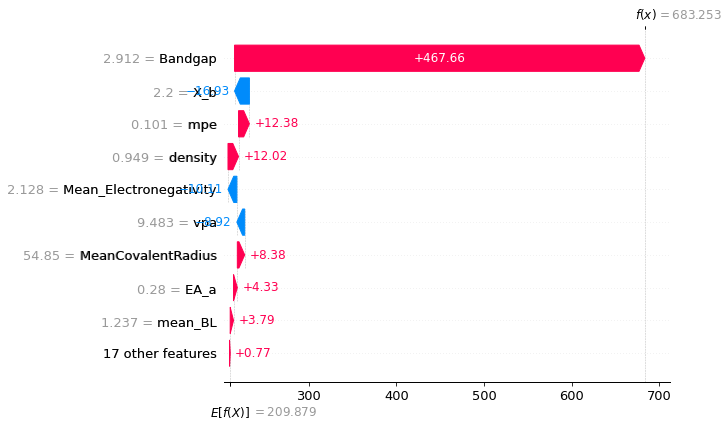

In [25]:
shap.plots.waterfall(shap_values[2]) # For the LiTiSe2 observation
#plt.savefig('final_images/local_interpretability_LiMnAs_2.png', bbox_inches='tight', dpi=1000)

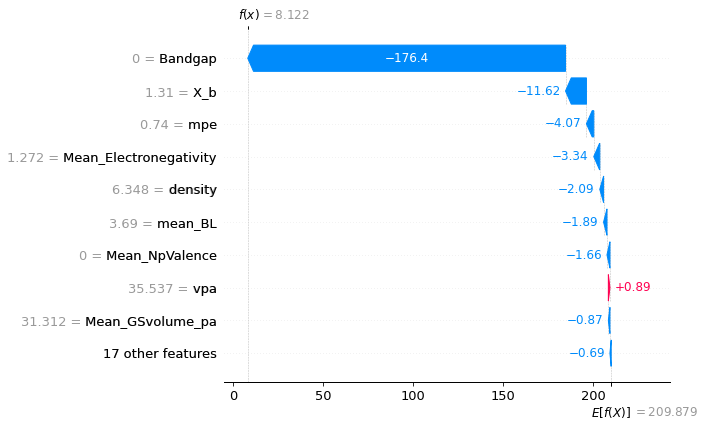

In [26]:
shap.plots.waterfall(shap_values[1]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_LiAl2Cu_2.png', bbox_inches='tight', dpi=1000)

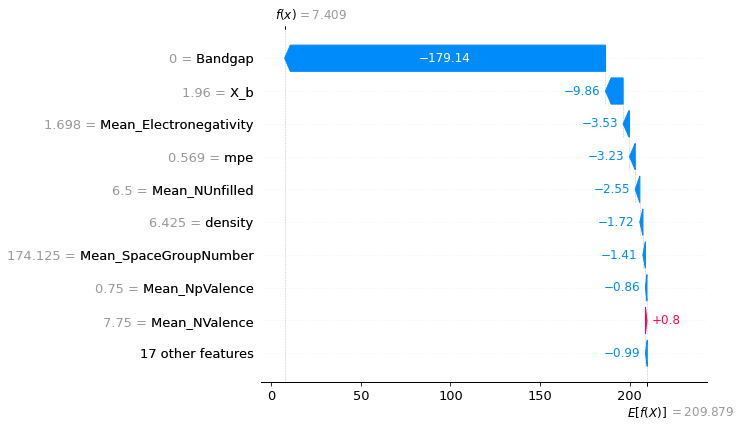

In [27]:
shap.plots.waterfall(shap_values[587]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_LiHfSe2_2.png', bbox_inches='tight', dpi=1000)

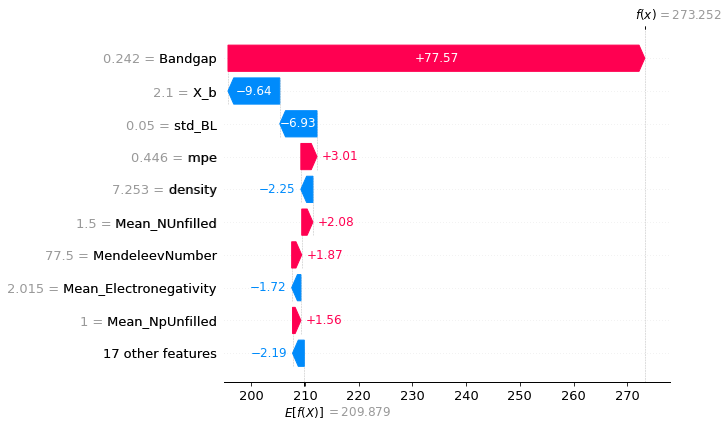

In [28]:
shap.plots.waterfall(shap_values[1527]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Al(WO2)2_2.png', bbox_inches='tight', dpi=1000)

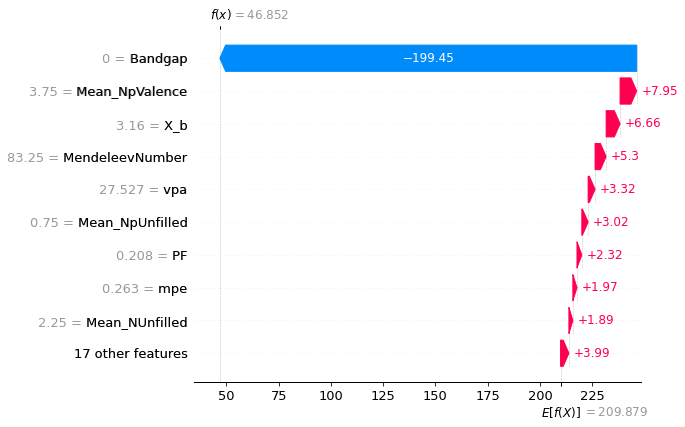

In [29]:
shap.plots.waterfall(shap_values[1547]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_Al(CoS2)2_2.png', bbox_inches='tight', dpi=1000)

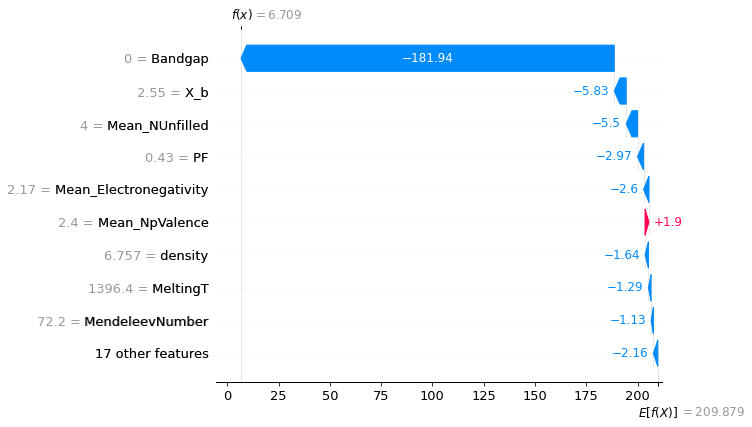

In [30]:
shap.plots.waterfall(shap_values[2009]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_KNbSe2_2.png', bbox_inches='tight', dpi=1000)

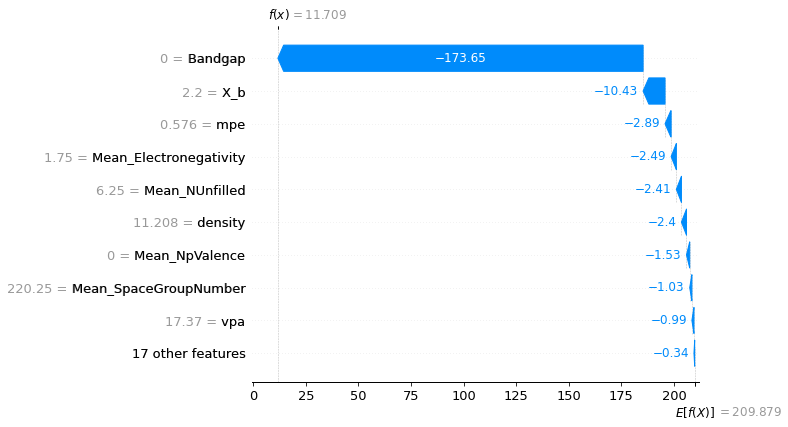

In [31]:
shap.plots.waterfall(shap_values[2042]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_KTiS2_2.png', bbox_inches='tight', dpi=1000)

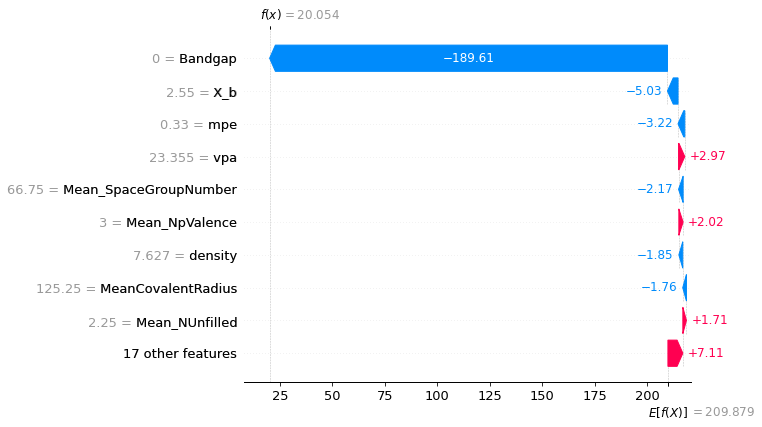

In [32]:
shap.plots.waterfall(shap_values[2236]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_MgWO3_2.png', bbox_inches='tight', dpi=1000)

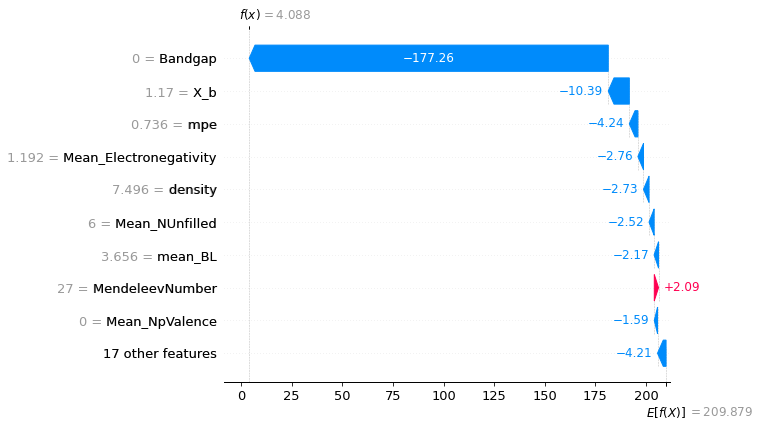

In [33]:
shap.plots.waterfall(shap_values[2311]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Mg(MoS2)2_2.png', bbox_inches='tight', dpi=1000)

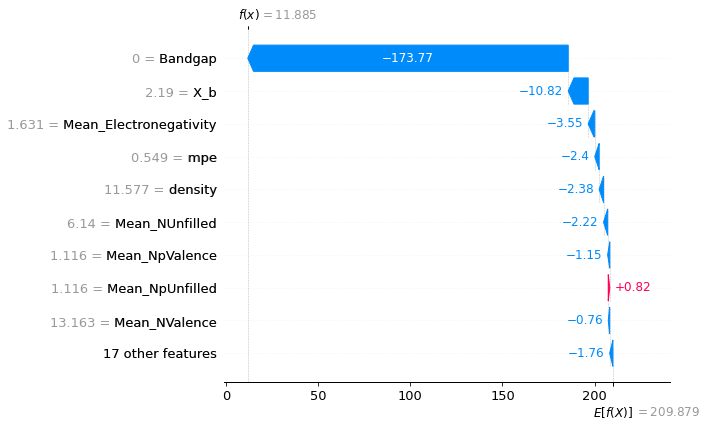

In [34]:
shap.plots.waterfall(shap_values[2496]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Na(V3S4)2_2.png', bbox_inches='tight', dpi=1000)

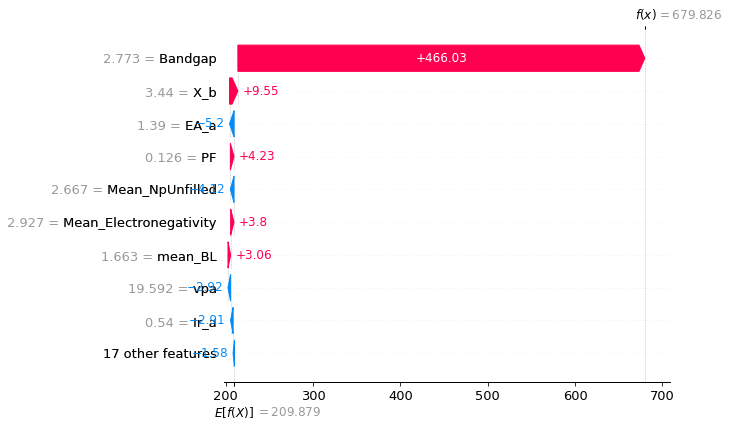

In [35]:
shap.plots.waterfall(shap_values[2761]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Zn(CoN)2_2.png', bbox_inches='tight', dpi=1000)

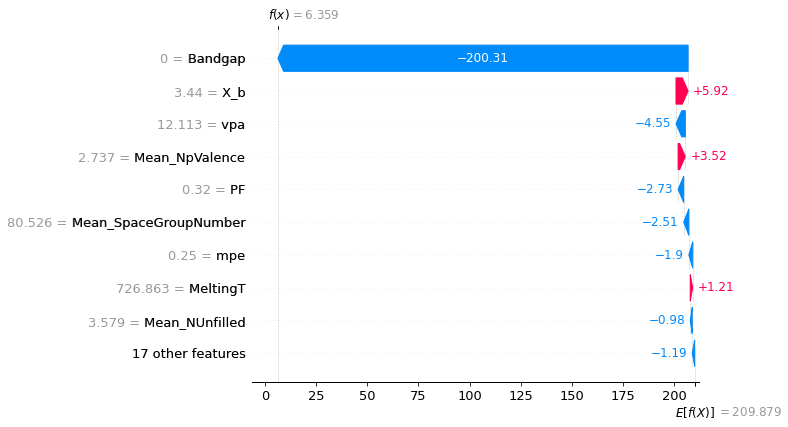

In [36]:
shap.plots.waterfall(shap_values[1820]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_CaFe(PO3)4_2.png', bbox_inches='tight', dpi=1000)

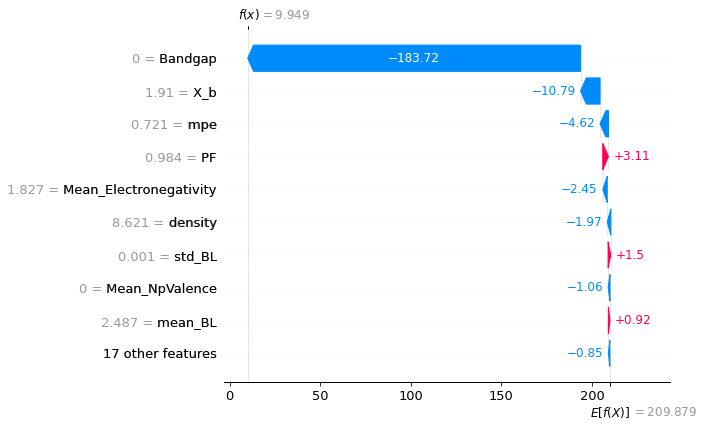

In [37]:
shap.plots.waterfall(shap_values[1806]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_CaTiNiP2O9_2.png', bbox_inches='tight', dpi=1000)

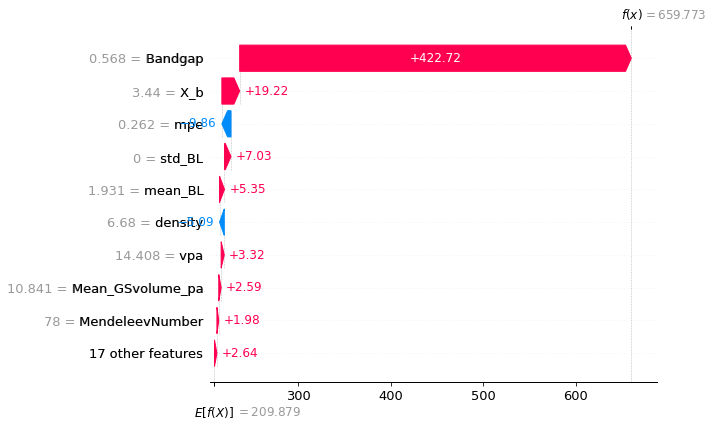

In [38]:
shap.plots.waterfall(shap_values[1770]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_CaPr(NiO3)2_2.png', bbox_inches='tight', dpi=1000)

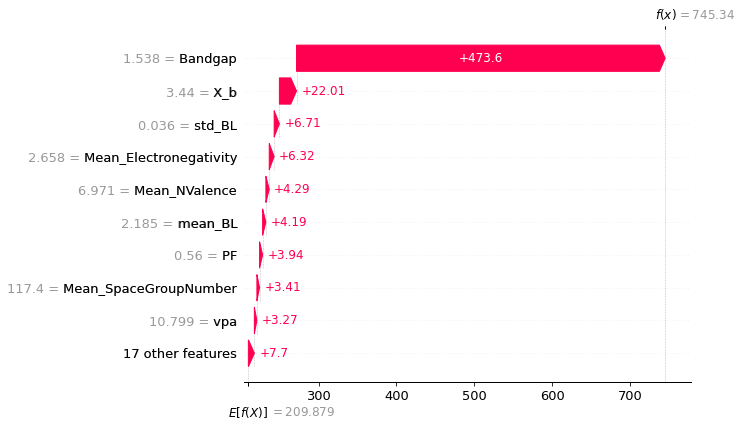

In [39]:
shap.plots.waterfall(shap_values[1719]) # For the LiAl2Cu observation
#plt.savefig('final_images3/local_interpretability_CaCo(PO3)4_2.png', bbox_inches='tight', dpi=1000)

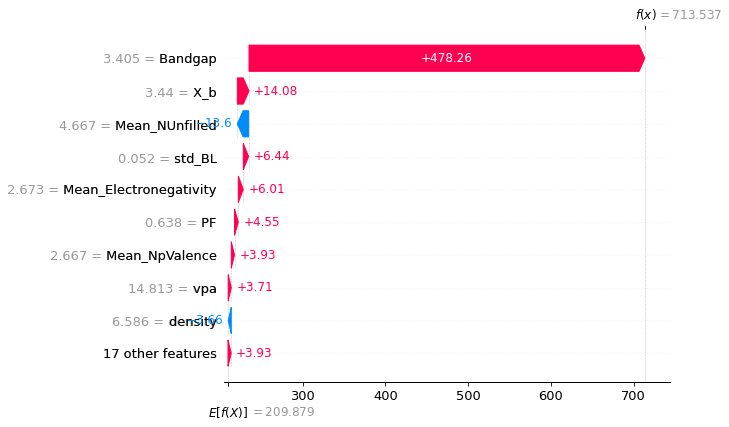

In [40]:
shap.plots.waterfall(shap_values[1644]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_CaCrF5_2.png', bbox_inches='tight', dpi=1000)

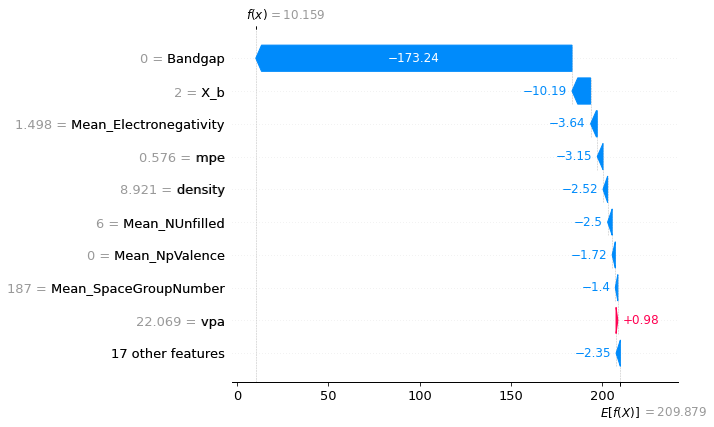

In [41]:
shap.plots.waterfall(shap_values[1602]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Ca3Nb2CoO9_2.png', bbox_inches='tight', dpi=1000)

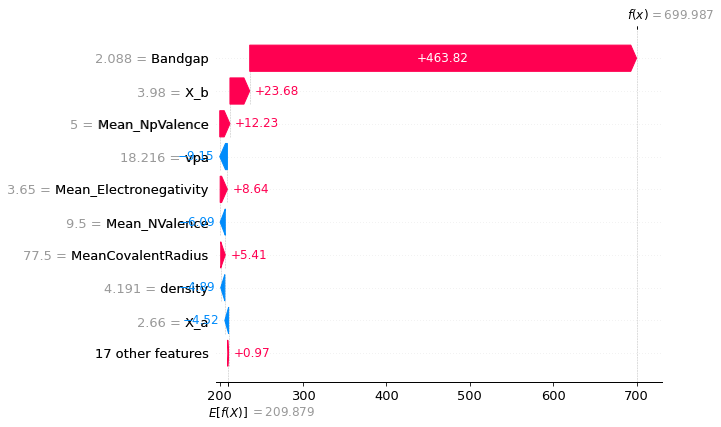

In [42]:
shap.plots.waterfall(shap_values[1493]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_LiV4OF11_2.png', bbox_inches='tight', dpi=1000)

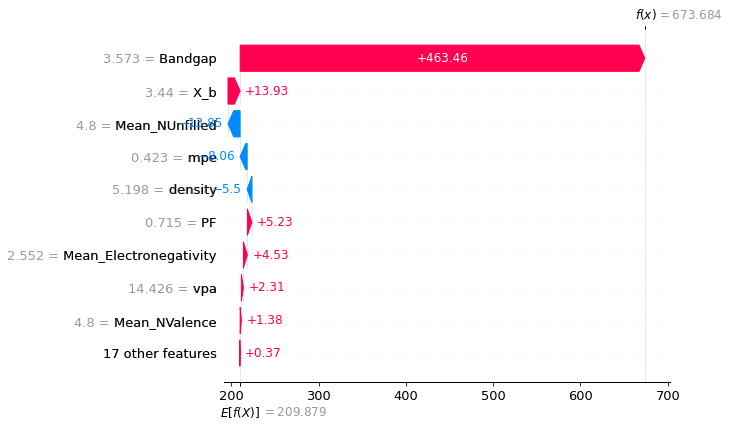

In [43]:
shap.plots.waterfall(shap_values[1436]) # For the LiAl2Cu observation
#plt.savefig('final_images/local_interpretability_Li5Ni2(PO4)3_2.png', bbox_inches='tight', dpi=1000)